In [1]:
import os
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn import preprocessing
from lib.clean import clean
from lib.data_prepare import data_prepare
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import precision_recall_curve
from lib.plot import plot
from lib.stats import stats
from sklearn.metrics import classification_report
from pathlib import Path

In [2]:
# params = {
#     input_data = 'go_aggregated_4.1_great1000.tsv',
#     is_pickle = False,
#     normalization = False,
#     feature_selection = True,
#     remove_low_freq_biome = True,
    
# }

### 1. read input
1.1 read MGnify

In [3]:
data_file = "go_aggregated_4.1_great1000.tsv"
df = pd.read_csv(data_file, sep="\t")
df = clean.rows_and_cols_quant_filter(df, start_col_index=7)
del df['version']
del df['exptype']
del df['Unnamed: 0']
df = df.iloc[:, 3:]
df

,biome,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0005976,GO:0008666,...,GO:0006064,GO:0000276,GO:0019357,GO:0006527,GO:0004114,GO:0034194,GO:0032183,GO:0007618,GO:0004520,GO:0033739
0,root:Environmental:Aquatic:Marine:Brackish,3.0,0.0,0.0,342.0,10.0,18.0,27.0,60.0,16.0,...,42.0,1.0,2.0,79.0,90.0,20.0,0.0,0.0,87.0,38.0
1,root:Engineered:Biogas plant,49.0,0.0,0.0,450.0,19.0,1.0,61.0,75.0,1.0,...,197.0,0.0,2.0,110.0,0.0,15.0,0.0,0.0,204.0,34.0
2,root:Engineered:Bioreactor,2.0,0.0,0.0,270.0,29.0,52.0,30.0,89.0,17.0,...,131.0,9.0,33.0,102.0,2.0,43.0,0.0,0.0,93.0,49.0
3,root:Host-associated:Mammals,0.0,0.0,0.0,26.0,0.0,9.0,2.0,15.0,0.0,...,41.0,1.0,0.0,12.0,1.0,15.0,0.0,0.0,8.0,5.0
4,root:Host-associated:Mammals,0.0,0.0,0.0,31.0,0.0,10.0,3.0,15.0,0.0,...,37.0,0.0,0.0,13.0,1.0,20.0,0.0,0.0,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27319,root:Host-associated:Human:Digestive system:Oral,0.0,0.0,0.0,13.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0
27320,root:Engineered:Wastewater,0.0,0.0,0.0,115.0,3.0,0.0,4.0,16.0,6.0,...,15.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,41.0,8.0
27321,root:Environmental:Aquatic:Marine,1.0,0.0,0.0,336.0,7.0,1.0,23.0,72.0,17.0,...,43.0,0.0,3.0,54.0,1.0,7.0,0.0,0.0,88.0,56.0
27322,root:Environmental:Aquatic:Marine,2.0,0.0,0.0,299.0,4.0,2.0,17.0,66.0,16.0,...,40.0,0.0,2.0,58.0,0.0,11.0,0.0,0.0,74.0,53.0


In [4]:
df[df.columns[1:]].sum(axis=1)

0        525552.0
1        705669.0
2        639535.0
3         93191.0
4        110094.0
           ...   
27319     10195.0
27320    152423.0
27321    433335.0
27322    360055.0
27323    432269.0
Length: 27324, dtype: float64

### 2. data prepare

In [5]:
# 1. normalization
# df = data_prepare.normalization(df, 'standard')
# 2. feature selection
df = stats.feature_selection(df, cutoff=0.9)
# 3. filter out low freq biome
df = clean.remove_low_freq(df, 'biome', 30)
# 4. split to train, val and test
df_train, df_val, df_test = data_prepare.dataset_split(df)
# 5. balance dataset
# df_train = data_prepare.dataset_balancing(df_train, 100)

### 5. Prepare Catboost Pool

In [6]:
df_train

,biome,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0005976,GO:0008666,...,GO:0016684,GO:0004650,GO:0030178,GO:0012511,GO:0030168,GO:0043657,GO:0016879,GO:0016977,GO:0006898,GO:0019357
4878,root:Host-associated:Human:Skin,0.0,0.0,0.0,54.0,3.0,1.0,7.0,7.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,1.0
24064,root:Host-associated:Human:Skin,2.0,0.0,0.0,18.0,2.0,1.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0
2092,root:Host-associated:Human:Digestive system:La...,4.0,0.0,0.0,484.0,1.0,0.0,131.0,90.0,0.0,...,50.0,76.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0
1412,root:Engineered:Solid waste:Composting,0.0,0.0,0.0,232.0,23.0,11.0,30.0,6.0,1.0,...,23.0,8.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0
16759,root:Host-associated:Human:Digestive system:La...,0.0,0.0,0.0,738.0,0.0,15.0,169.0,20.0,0.0,...,32.0,64.0,0.0,0.0,0.0,0.0,81.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19653,root:Host-associated:Human:Digestive system:La...,2.0,0.0,0.0,28.0,0.0,1.0,4.0,4.0,0.0,...,1.0,14.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
13345,root:Environmental:Aquatic:Lentic:Brackish,0.0,0.0,0.0,5.0,0.0,6.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
25668,root:Host-associated:Human:Skin,83.0,0.0,0.0,2815.0,68.0,27.0,182.0,162.0,0.0,...,256.0,3.0,0.0,0.0,0.0,0.0,568.0,15.0,0.0,0.0
5030,root:Host-associated:Human:Skin,0.0,0.0,0.0,10.0,1.0,0.0,2.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0


In [7]:
X_train = df_train.iloc[:, 1:]
y_train = df_train['biome']
X_train_pool = Pool(
    data=X_train,
    label=y_train,
    # cat_features=np.where(X_train.dtypes != float)[0],
)

In [8]:
X_val = df_val.iloc[:, 1:]
y_val = df_val['biome']
X_val_pool = Pool(
    data=X_val,
    label=y_val,
    # cat_features=np.where(X_val.dtypes != float)[0],
)

### 6. Model training

In [9]:
# Init the model
model = CatBoostClassifier(
        loss_function='MultiClass',
        custom_metric='Accuracy',
        learning_rate=0.15,
        random_seed=42,
        l2_leaf_reg=3,
        iterations=2000,
        task_type="GPU",
)

In [10]:
# Train
model.fit(
    X_train_pool,
    eval_set=X_val_pool,
    logging_level='Verbose',
    plot=True,
    snapshot_file='missing'
)

Path("output").mkdir(exist_ok=True)
model.save_model("output/model.json",
           format="json",
           export_parameters=None,
           pool=X_train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7463293	test: 1.7520230	best: 1.7520230 (0)	total: 80.6ms	remaining: 2m 41s
1:	learn: 1.5479836	test: 1.5599029	best: 1.5599029 (1)	total: 156ms	remaining: 2m 36s
2:	learn: 1.3991746	test: 1.4180999	best: 1.4180999 (2)	total: 229ms	remaining: 2m 32s
3:	learn: 1.3054089	test: 1.3324744	best: 1.3324744 (3)	total: 297ms	remaining: 2m 28s
4:	learn: 1.2484282	test: 1.2753348	best: 1.2753348 (4)	total: 346ms	remaining: 2m 18s
5:	learn: 1.1850713	test: 1.2139936	best: 1.2139936 (5)	total: 411ms	remaining: 2m 16s
6:	learn: 1.1401495	test: 1.1701093	best: 1.1701093 (6)	total: 468ms	remaining: 2m 13s
7:	learn: 1.0963916	test: 1.1272112	best: 1.1272112 (7)	total: 541ms	remaining: 2m 14s
8:	learn: 1.0556874	test: 1.0870081	best: 1.0870081 (8)	total: 595ms	remaining: 2m 11s
9:	learn: 1.0146482	test: 1.0469333	best: 1.0469333 (9)	total: 659ms	remaining: 2m 11s
10:	learn: 0.9884494	test: 1.0217955	best: 1.0217955 (10)	total: 705ms	remaining: 2m 7s
11:	learn: 0.9665232	test: 0.9999399	best

In [11]:
X_test = df_test.iloc[:, 1:]
y_test = df_test['biome']

model.score(X_test, y_test)

0.9042990654205607

In [12]:
model.score(X_val, y_val)

0.9007476635514019

In [13]:
model.score(X_train, y_train)

0.9986648152104252

### 7. Training curve

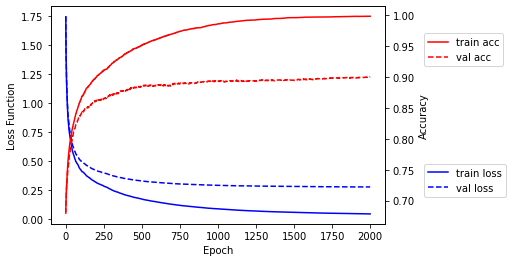

In [14]:
plot.plot_training_curve("catboost_info", "MultiClass", "Accuracy", 2000)

### 8. F1 report

In [15]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

                                                                                  precision    recall  f1-score   support

                                                      root:Engineered:Bioreactor      0.739     0.850     0.791        20
                         root:Engineered:Bioremediation:Terephthalate:Wastewater      1.000     1.000     1.000         9
                                               root:Engineered:Built environment      1.000     0.750     0.857         8
                                                 root:Engineered:Food production      1.000     0.500     0.667         4
                             root:Engineered:Food production:Fermented beverages      1.000     0.833     0.909         6
                                          root:Engineered:Solid waste:Composting      1.000     0.750     0.857         4
                                                      root:Engineered:Wastewater      0.967     0.967     0.967        30
                       

In [16]:
# save f1 report to tsv file
plot.save_f1_report(y_pred, y_test)

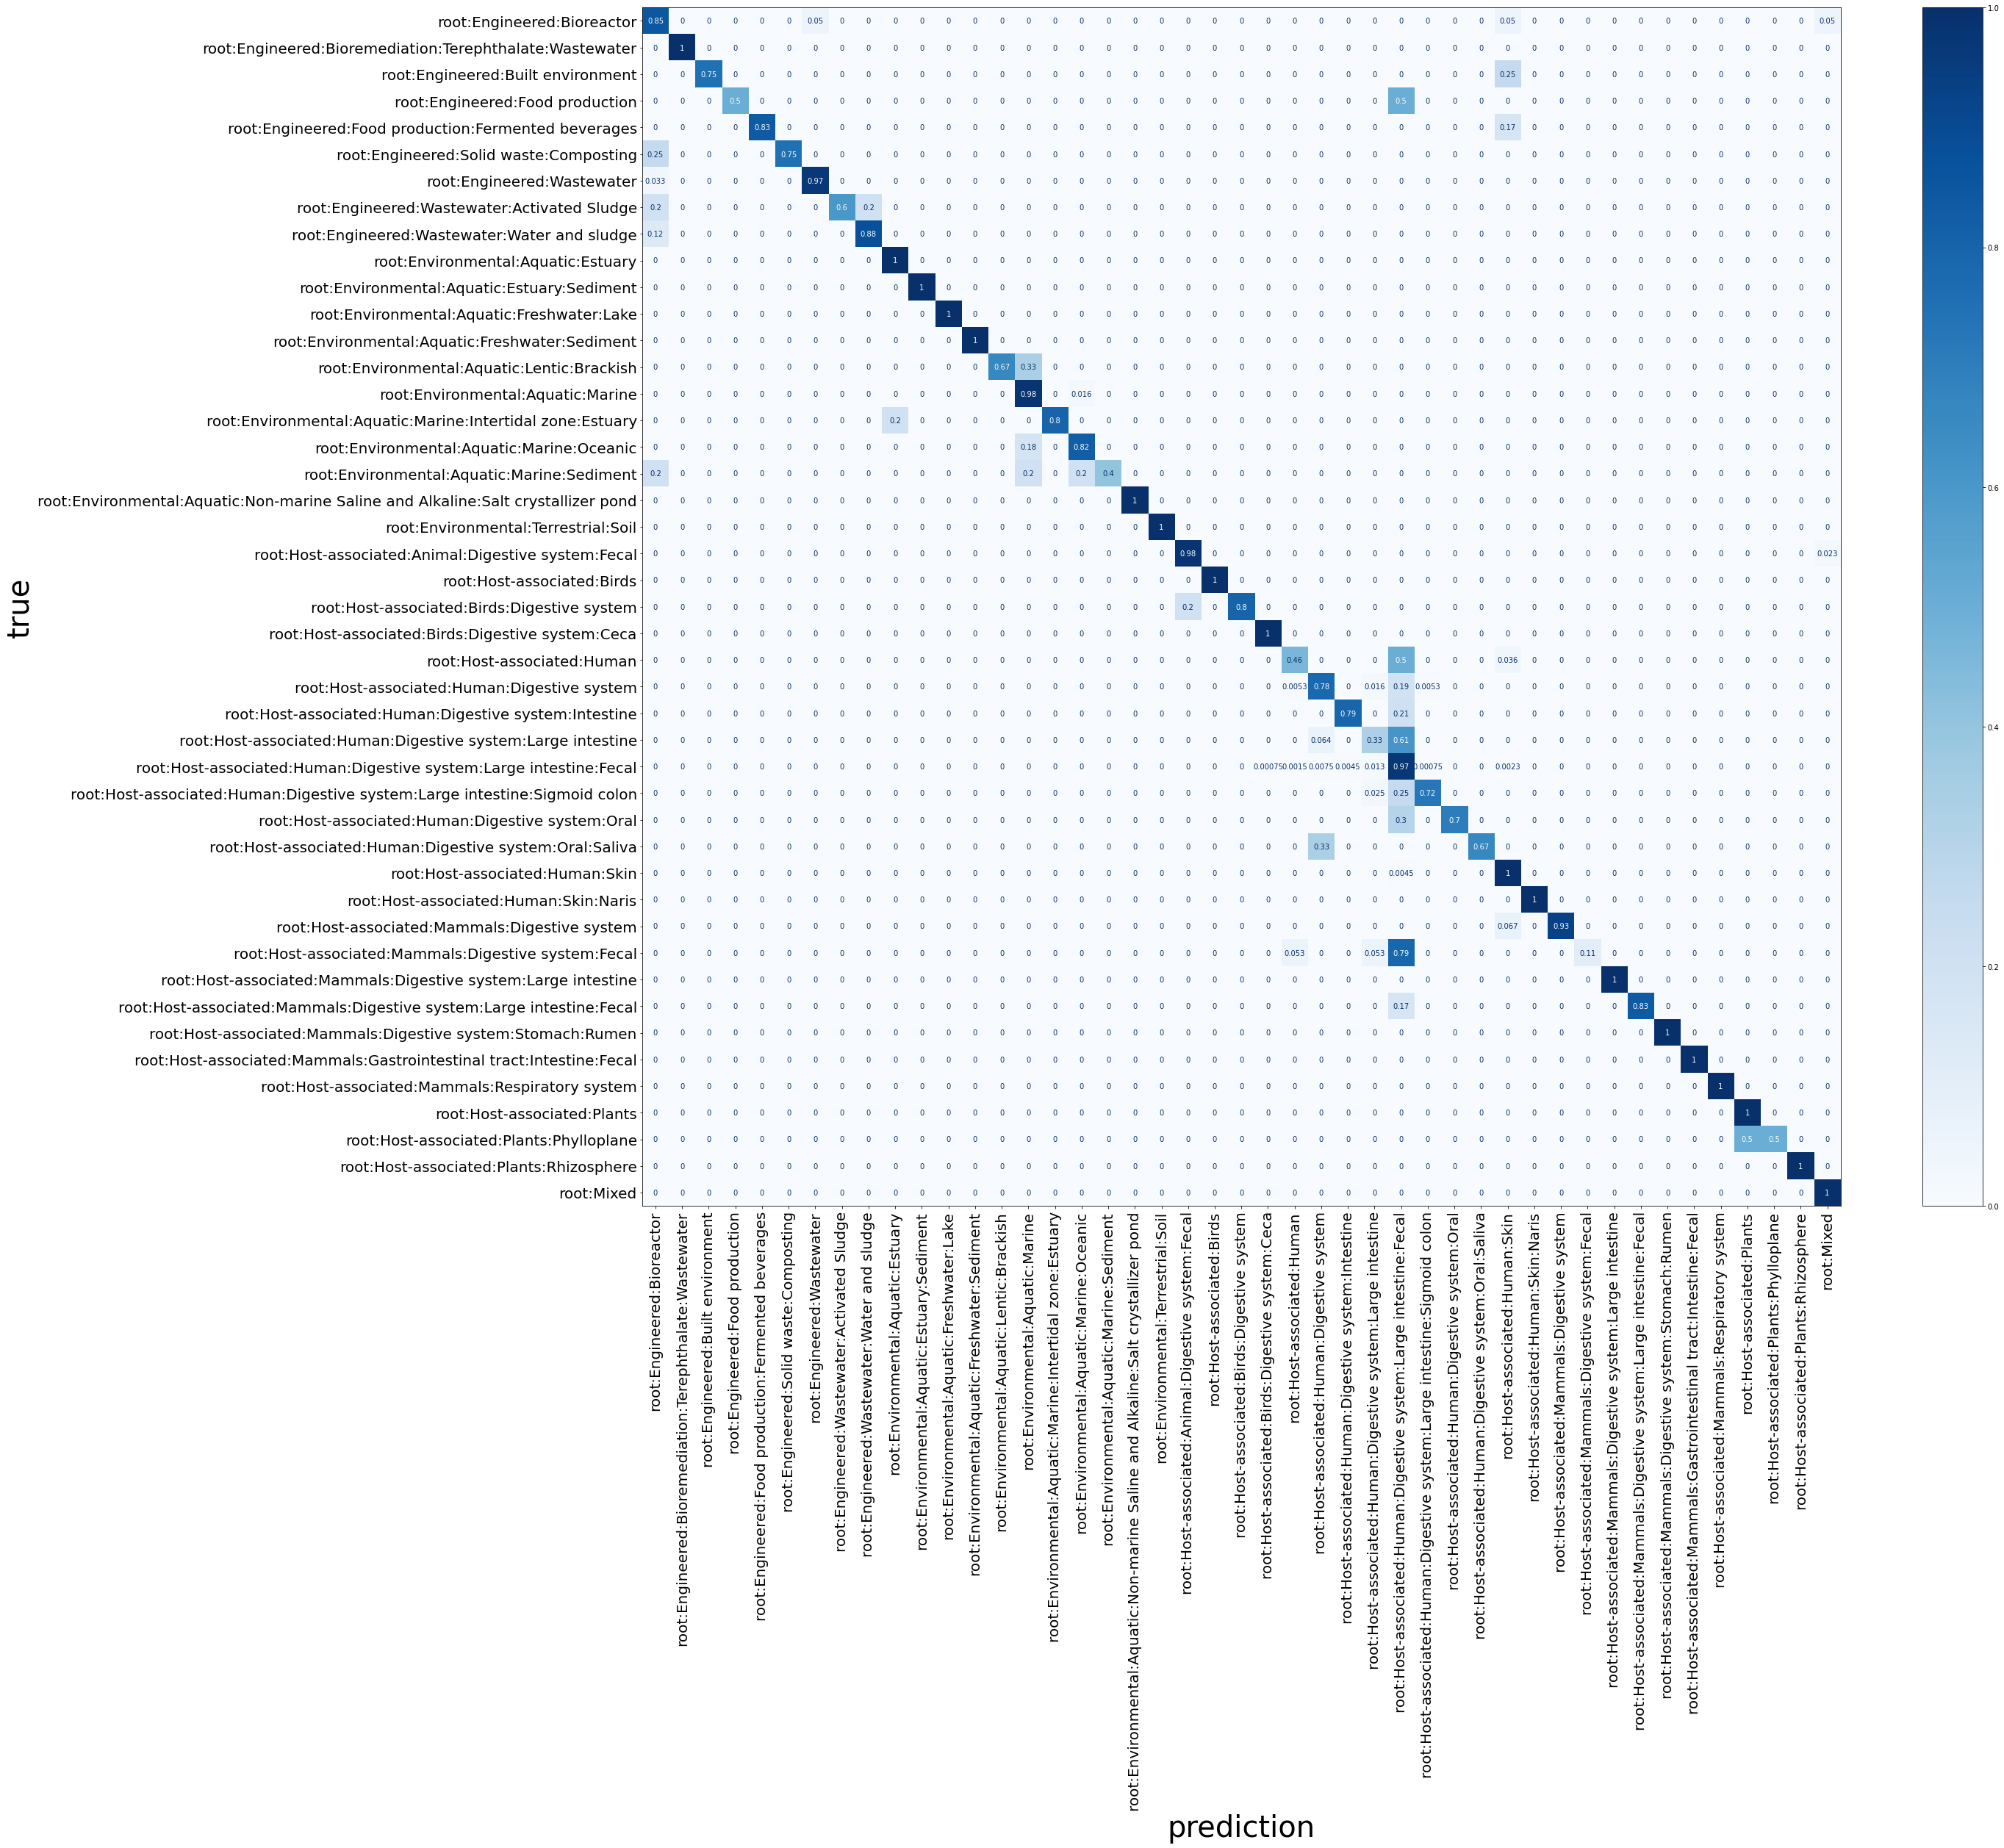

In [17]:
# plot confusion matrix
plot.confusion_matrix(model, X_test, y_test)